# Import modules for data preparation

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import glob
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
'''import nltk
nltk.download('stopwords')'''

"import nltk\nnltk.download('stopwords')"

In [2]:
filenames = list(glob.glob("data/*"))
dataframes = [pd.read_csv(file) for file in filenames]

In [3]:
metadata = pd.concat(dataframes)
metadata.head(10)

,projectname,classification,commenttext
0,apache-ant-1.7.0,DEFECT,// FIXME formatters are not thread-safe
1,apache-ant-1.7.0,DEFECT,"// XXX: (Jon Skeet) The comment ""if it hasn't been done already"" may // not be strictly true. wrapper.maybeConfigure() won't configure the same // attributes/text more than once, but it may well add the children again, // unless I've missed something."
2,apache-ant-1.7.0,DEFECT,"// I hate to admit it, but we don't know what happened // here. Throw the Exception."
3,apache-ant-1.7.0,DEFECT,"// Just a note: StarTeam has a status for NEW which implies // that there is an item on your local machine that is not // in the repository. These are the items that show up as // NOT IN VIEW in the Starteam GUI. // One would think that we would want to perhaps checkin the // NEW items (not in all cases! - Steve Cohen 15 Dec 2001) // Unfortunately, the sdk doesn't really work, and we can't // actually see anything with a status of NEW. That is why // we can just check out everything here without worrying // about losing anything."
4,apache-ant-1.7.0,DEFECT,// the generated classes must not be added in the generic JAR! // is that buggy on old JOnAS (2.4) ??
5,apache-ant-1.7.0,DEFECT,// todo: is this comment still relevant ?? // FIXME: need to use a SAXSource as the source for the transform // so we can plug in our own entity resolver
6,apache-ant-1.7.0,DEFECT,"// This is turned off temporarily. There appears to be a bug // in SelectorUtils.matchPattern() where it is recursive on // Windows even if no ** is in pattern. //assertEquals(""FFFTFFFFFFFF"", results); // Unix // vs //assertEquals(""FFFTFFFFTFFF"", results); // Windows"
7,apache-ant-1.7.0,DEFECT,// pattern now holds ** while string is not exhausted // this will generate false positives but we can live with that.
8,apache-ant-1.7.0,DEFECT,"// FIXME: Is ""No Namespace is Empty Namespace"" really OK?"
9,apache-ant-1.7.0,DEFECT,// FIXME this is actually not very cpu cycles friendly as we are converting from // dos to java while the underlying Sun implementation will convert // from java to dos time for internal storage...


## Create labels for SATD
- <b> Is important that they are numeric not string type for feeding into CNN </b>
- <b> Without Classification is non SATD no label 0, SATD label 1

In [5]:
# Is important that text labels are converted into numeric for NN
metadata['label'] = np.where(metadata.classification == 'WITHOUT_CLASSIFICATION', 0, 1)
metadata.head()

,projectname,classification,commenttext,label
0,apache-ant-1.7.0,DEFECT,// FIXME formatters are not thread-safe,1
1,apache-ant-1.7.0,DEFECT,"// XXX: (Jon Skeet) The comment ""if it hasn't been done already"" may // not be strictly true. wrapper.maybeConfigure() won't configure the same // attributes/text more than once, but it may well add the children again, // unless I've missed something.",1
2,apache-ant-1.7.0,DEFECT,"// I hate to admit it, but we don't know what happened // here. Throw the Exception.",1
3,apache-ant-1.7.0,DEFECT,"// Just a note: StarTeam has a status for NEW which implies // that there is an item on your local machine that is not // in the repository. These are the items that show up as // NOT IN VIEW in the Starteam GUI. // One would think that we would want to perhaps checkin the // NEW items (not in all cases! - Steve Cohen 15 Dec 2001) // Unfortunately, the sdk doesn't really work, and we can't // actually see anything with a status of NEW. That is why // we can just check out everything here without worrying // about losing anything.",1
4,apache-ant-1.7.0,DEFECT,// the generated classes must not be added in the generic JAR! // is that buggy on old JOnAS (2.4) ??,1


In [6]:
#Check how many are SATD 
metadata['label'].value_counts()

0    58204
1     4071
Name: label, dtype: int64

In [7]:
#Check how many projects in dataset
metadata.projectname.unique()

array(['apache-ant-1.7.0', 'apache-jmeter-2.10', 'argouml',
       'columba-1.4-src', 'emf-2.4.1', 'hibernate-distribution-3.3.2.GA',
       'jEdit-4.2', 'jfreechart-1.0.19', 'jruby-1.4.0', 'sql12'],
      dtype=object)

# Select the desired project name/s to train model and store in df

In [8]:
df = metadata[metadata.projectname == 'apache-jmeter-2.10']
print(df.isnull().sum())
df.info()

projectname       0
classification    0
commenttext       0
label             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8057 entries, 0 to 8056
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   projectname     8057 non-null   object
 1   classification  8057 non-null   object
 2   commenttext     8057 non-null   object
 3   label           8057 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 283.3+ KB


## 1] Preprocessing:

#### 1. Remove tags, punctuations, stop words, special characters and return (X_clean and y) as np arrays
#### 2. Split data in train and test. Remember Xclean and y should reflect metadata used for training 

In [10]:
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')

    return TAG_RE.sub('', text)
    
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    #print(sentence)
    return sentence

def prepare_data(apache_ant_df):
    X_clean = []
    sentences = list(apache_ant_df['commenttext'])

    for sen in sentences:
        X_clean.append(preprocess_text(sen))

    print(X_clean[:3], "\n\n*************************")
    X_clean = np.array(X_clean)
    y = np.array(apache_ant_df.label)

    print("Cleaned corpus shape:", X_clean.shape, y.shape)
    return X_clean, y

def split_data(df):
    X_clean, y = prepare_data(df)
    X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.20, random_state=42)
    print("Train set:",X_train.shape, y_train.shape)
    print("Validation set:", X_val.shape, X_val.shape)
    return X_train, X_val, y_train, y_val

In [11]:
X_train, X_val, y_train, y_val = split_data(df)

[' Don try restoring URL TODO wy ', ' TODO Why clone return value This reference right need separate copy ', ' Fix bug JVMs return true false rather True False type editor getAsText method '] 

*************************
Cleaned corpus shape: (8057,) (8057,)
Train set: (6445,) (6445,)
Validation set: (1612,) (1612,)


In [12]:
X_train

array([' Original match behaviour', ' NON NLS NON NLS ',
       ' ensure interrupt cannot overlap shutdown', ...,
       ' NON NLS NON NLS Check form data NON NLS Get form field name NON NLS ',
       ' B The keys either JMeterTreeNode TestElement', ' GuardedBy '],
      dtype='<U1447')

## 2] Tokenize the splitted data and convert them into number sequences and add post padding.
####  <b> Final output stored as (X_train_padded, X-val_padded) and (y_train and y_val) <b>

In [14]:
def prepare_data(X_train, X_val, y_train, y_val):
    
    '''Returns the padded X-train and X-val with corresponding labels and also the length of longest sentence,
    vocab size and word index'''
    
    #Step 2: Use keras to tokenize words and find word.index'length for getting number of unique words i.e vocab size

    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                          lower=True)

    tokenizer.fit_on_texts(X_train)

    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1
    print('VOCAB SIZE: Found %s unique tokens.' % len(word_index))

    # Step 3: Embed the sentences into numbers using text to sequences

    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_valid = tokenizer.texts_to_sequences(X_val)

    # Step 4: next step is to find the number of words in the longest sentence and then to apply 
    #padding to the sentences having shorter lengths than the length of the longest sentence

    from nltk.tokenize import word_tokenize
    word_count = lambda sentence: len(word_tokenize(sentence))
    longest_sentence = max(X_train, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    print("Longest sentence length: ",  length_long_sentence)
    
    print("**********************")
    
    #Step 5: Pad zeros at the end using the length of the longest word 
    X_train_padded = pad_sequences(sequences_train,length_long_sentence, padding='post')
    X_val_padded = pad_sequences(sequences_valid,padding='post', maxlen = length_long_sentence)


    print('Shape of X train and X validation tensor:', X_train_padded.shape,X_val_padded.shape)
    print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)
    
    return X_train_padded, X_val_padded, y_train, y_val, vocab_size, word_index, length_long_sentence

In [15]:
X_train_padded, X_val_padded, y_train, y_val, vocab_size, word_index, length_long_sentence= prepare_data(X_train, X_val, y_train, y_val)

VOCAB SIZE: Found 3428 unique tokens.
Longest sentence length:  173
**********************
Shape of X train and X validation tensor: (6445, 173) (1612, 173)
Shape of label train and validation tensor: (6445,) (1612,)


In [16]:
# Check padded data 
print(X_train_padded)

[[154  98 447 ...   0   0   0]
 [  1   2   1 ...   0   0   0]
 [ 68 638 118 ...   0   0   0]
 ...
 [  1   2   1 ...   0   0   0]
 [ 64  28 301 ...   0   0   0]
 [187   0   0 ...   0   0   0]]


## 3] Build embedding matrix using the above word index

In [46]:
def build_embedding_matrix_word2vec(vocab_size, word_index):
    import gensim
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess

    from gensim.models.keyedvectors import KeyedVectors
    path_to_word2vec = 'E:/RIT/GA-TECHNICAL DEBTS/rudimentary-stages/cnn-word2vec/GoogleNews-vectors-negative300.bin'
    word_vectors = KeyedVectors.load_word2vec_format(path_to_word2vec, binary=True)
    
    
    EMBEDDING_DIM= 300
    vocab_size = vocab_size
    
    #Size of embed matrix must be = vocab sizeV * dimension of embeding
    #Step 6: Generate an embedding matrix to get embeddings representaion of words in our corpus
    #Our embedding_matrix now contains pretrained word embeddings for the words in our corpus.
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

    for word, i in word_index.items():
        if i>=vocab_size:
            continue
        try:
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
    
    return embedding_matrix

#TOD0: Add Elmo emebddings function here

def build_embedding_matrix_glove(vocab_size, word_index):
    
    path_to_glove = 'E:/RIT/GA-TECHNICAL DEBTS/rudimentary-stages/lstm-apache-ant-glove/data/glove.6B.300d.txt'
    glove_file = open(path_to_glove, encoding="utf8")
    embeddings_dictionary = dict()
    
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
        
    glove_file.close()
    
    print('Found %s word vectors.' % len(embeddings_dictionary))
    
    EMBEDDING_DIM= 300
    vocab_size = vocab_size
    
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    
    for word, index in word_index.items():
        if index>=vocab_size:
            continue
        try:
            embedding_vector = embeddings_dictionary.get(word)
            embedding_matrix[index] = embedding_vector
        except KeyError:
            embedding_matrix[index]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
    
    return embedding_matrix

    
    

In [47]:
embedding_matrix =  build_embedding_matrix_word2vec(vocab_size, word_index)

In [43]:
embedding_matrix_glove =  build_embedding_matrix_glove(vocab_size, word_index)

Found 400000 word vectors.


## 4] Build a custom weighted loss function : handle unbalanced dataset

In [29]:
def sklearn_weighted_loss(y_train):
    # Calculate the weights for each class so that we can balance the data
    #The minority class will have a higher class weight
    from sklearn.utils import class_weight
    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(y_train),
                                                y_train)
    print("Resultant weight:", weights)
    sklearn_weight = {0: weights[0], 1: weights[1]}
    return sklearn_weight

def weighted_loss(y_train):
    
    '''Link: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data'''

    neg, pos = np.bincount(y_train)
    total = neg + pos
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    return class_weight

In [31]:
# Check class weight results
custom_class_weights = weighted_loss(y_train)
print("Custom:", custom_class_weights)

#or use sklearn computed 
sklearn_weights= sklearn_weighted_loss(y_train)

Weight for class 0: 0.52
Weight for class 1: 10.92
Custom: {0: 0.5239837398373983, 1: 10.923728813559322}
Resultant weight: [ 0.52398374 10.92372881]


### Build Embedding layer to feed into the network

In [45]:
embedding_matrix.shape

(3429, 300)

In [44]:
embedding_matrix_glove.shape

(3429, 300)

In [21]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

### Make sure you are using correct embedidng matrix either W2V or Glove

In [23]:
EMBEDDING_DIM = 300
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)

## 5] Build COV2D network 

In [86]:
filter_sizes = [1,2,3,4,5,6]
num_filters = 256
drop = 0.5
decay = 2*1e-3


deep_inputs = Input(shape=(length_long_sentence,))
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)(deep_inputs)
reshape = Reshape((length_long_sentence,EMBEDDING_DIM,1))(embedding)
convs = []
for filter_size in filter_sizes:
    
    conv = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
    maxpool =  MaxPooling2D((length_long_sentence - filter_size + 1, 1), strides=(1,1))(conv)
    convs.append(maxpool)
merged_tensor = concatenate(convs, axis=1)

flatten = Flatten()(merged_tensor)
reshape = Reshape((len(filter_sizes)*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
cnn2d_model = Model(deep_inputs, output)

In [87]:
cnn2d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss',  min_delta=0.001)]
cnn2d_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 173)]        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 173, 300)     1028700     input_13[0][0]                   
__________________________________________________________________________________________________
reshape_19 (Reshape)            (None, 173, 300, 1)  0           embedding_13[0][0]               
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 173, 1, 256)  77056       reshape_19[0][0]                 
____________________________________________________________________________________________

In [88]:
cnn2d_history = cnn2d_model.fit(X_train_padded, y_train, batch_size=32, epochs=150, validation_split=0.2, class_weight=sklearn_weights, callbacks=callbacks)

Epoch 1/150
162/162 [==============================] - 9s 57ms/step - loss: 0.7796 - acc: 0.2983 - val_loss: 0.4324 - val_acc: 0.9612
Epoch 2/150
162/162 [==============================] - 10s 59ms/step - loss: 0.7726 - acc: 0.7477 - val_loss: 0.4324 - val_acc: 0.9612


In [89]:
score  = cnn2d_model.evaluate(X_val_padded, y_val, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

51/51 [==============================] - 1s 15ms/step - loss: 0.4394 - acc: 0.9510
Test Loss: 0.43943437933921814
Test Accuracy: 0.9509925842285156


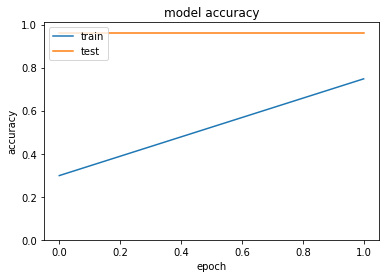

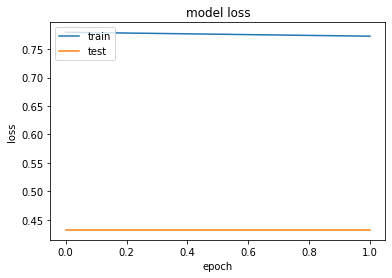

In [90]:
plt.plot(cnn2d_history.history['acc'])
plt.plot(cnn2d_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.ylim([0,1.01])
plt.show()

plt.plot(cnn2d_history.history['loss'])
plt.plot(cnn2d_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [91]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = cnn2d_model.predict(X_val_padded)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print("Precision:", round(precision_score(y_val, y_pred , average="macro"),2))
print("Recall:", round(recall_score(y_val, y_pred , average="macro"),2))
print("F1 Score:", round(f1_score(y_val, y_pred , average="macro"),2))

Precision: 0.48
Recall: 0.5
F1 Score: 0.49


C:\Users\ketak\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
